In [1]:
import warnings

import matplotlib as mpl
from IPython import get_ipython

import pymor.tools.random

ip = get_ipython()
if ip is not None:
    ip.run_line_magic('matplotlib', 'inline')

warnings.filterwarnings('ignore', category=UserWarning, module='torch')

pymor.tools.random._default_random_state = None

mpl.rcParams['figure.facecolor'] = (1.0, 1.0, 1.0, 0.0)


Loading pyMOR defaults from file /builds/pymor/pymor/docs/source/pymor_defaults.py


# Tutorial: Model order reduction for port-Hamiltonian systems

In the [first section](#port-hamiltonian-lti-systems), we introduce the class of
port-Hamiltonian systems and their relationship to two other system-theoretic properties called
*passivity* and *positive realness*. After introducing a toy example in
the [second section](#a-toy-problem-mass-spring-damper-chain), we
look into structure-preserving model reduction schemes for port-Hamiltonian systems
in the [third section](#structure-preserving-model-order-reduction).

## Port-Hamiltonian LTI systems

Port-Hamiltonian systems have several favorable properties for modeling, control and
simulation, for example, composability and stability. Furthermore, they adhere to a
power balance equation. Port-Hamiltonian systems are especially suited for
network-based modeling and problems involving multi-physics phenomena. We refer to {cite}`MU23`
for a general introduction to port-Hamiltonian descriptor systems and their applications.

We say a LTI system is *port-Hamiltonian* if it can be expressed as

```{math}
E \dot{x}(t) & = (J - R) Q x(t) + (G-P) u(t), \\
y(t) & = (G+P)^T Q x(t) + (S-N) u(t),
```

with {math}`H := Q^T E`, and if the structure matrix

```{math}
\Gamma :=
\begin{bmatrix}
    J & G \\
    -G^T & N
\end{bmatrix}
```

and the dissipation matrix

```{math}
\mathcal{W} :=
\begin{bmatrix}
    R & P \\
    P^T & S
\end{bmatrix}
```

satisfy
{math}`H = H^T \succ 0`,
{math}`\Gamma^T = -\Gamma`, and
{math}`\mathcal{W} = \mathcal{W}^T \succcurlyeq 0`.

The quadratic (energy) function {math}`\mathcal{H}(x) := \tfrac{1}{2} x^T H x`,
typically called Hamiltonian, corresponds to the energy stored in the system. In
applications, {math}`E` and/or {math}`Q` often are identity matrices.

It is known that if the LTI system is minimal and stable, the following are equivalent:

- The system is passive.
- The system is port-Hamiltonian.
- The system is positive real.

See for example {cite}`BU22` for more details.

In pyMOR, there exists a `PHLTIModel` class. Currently, pyMOR only supports
port-Hamiltonian systems with nonsingular E. `PHLTIModel` inherits from
`LTIModel`, so `PHLTIModel` can be used with all reductors that expect
an `LTIModel`. For model reduction, it is often desirable to preserve the
port-Hamiltonian structure, i.e., to compute a ROM that is also port-Hamiltonian.

If desired, a passive `LTIModel` can be converted into a `PHLTIModel` using
the `from_passive_LTIModel` method.
Consequentely, one option to preserve port-Hamiltonian structure is to use a reductor
that preserves passivity (but returns a ROM of type `LTIModel`) and convert the
ROM into a `PHLTIModel` in a post-processing step.

## A toy problem: Mass-spring-damper chain

As a toy problem, we use a mass-spring-damper chain, which can be formulated
as a port-Hamiltonian system (see {cite}`GPBV12`):

```{image} msd_example.svg
:alt: MSD example
:width: 60%
```

Here, the spring constants are denoted by {math}`k_i` and the damping constants by
{math}`c_i`, {math}`i=1,\dots,n/2`.
The inputs {math}`u_1` and {math}`u_2` are the external forces on the first two
masses {math}`m_1` and {math}`m_2`. The system outputs {math}`y_1` and {math}`y_2`
correspond to the velocities of the first two masses {math}`m_1` and {math}`m_2`.
The toy problem is included in pyMOR in the {mod}`pymor.models.examples` module as
`msd_example`.

## Structure-preserving model order reduction

pyMOR provides three reductors which can be used for model order reduction
while preserving the port-Hamiltonian structure:

- pH-IRKA (`PHIRKAReductor`) {cite}`GPBV12`,
- PRBT (`PRBTReductor`) {cite}`DP84,GA04,HJS94`,
- passivity preserving model reduction via spectral factorization
  (`SpectralFactorReductor`) {cite}`BU22`.

In this section, we apply all three reductors on our toy example and compare
their performance. All three reductors are described in {cite}`BU22` in more detail.

Note: Currently, the `PRBTReductor` and
`SpectralFactorReductor` reductors require
the symmetric part of {math}`D` (i.e., the $S$ matrix in the port-Hamiltonian system)
to be nonsingular. The MSD example has a zero {math}`D` matrix. Therefore,
we have to add a small regularization feedthrough term, i.e., we replace $D$ with
$D+\varepsilon I_m$. This is a limitation of the current implementation since the
numerical solution of the KYP-LMI is obtained by solving a related Riccati
equation, for instance

```{math}
A^T X E + E^T X A+ (C^T - E^T X B) (D + D^T)^{-1} (C - B^T X E) = 0,
```

which is only possible if $D + D^\top$ is nonsingular.
For `from_passive_LTIModel`, $D + D^\top$ must be
nonsingular for the same reasons.

In [2]:
import numpy as np
from pymor.models.examples import msd_example

fom = msd_example(50, 2)

# tolerance for solving the Riccati equation instead of KYP-LMI
# by introducing a regularization feedthrough term D
# (required for PRBTReductor and SpectralFactorReductor reductors)
S = fom.S.matrix.copy()
S += np.eye(S.shape[0]) * 1e-12

fom = fom.with_(S=fom.S.with_(matrix=S),
                solver_options={'ricc_pos_lrcf': 'slycot'})

The `ricc_pos_lrcf` solver option refers to the solver used for the underlying
Riccati equation relevant for `PRBTReductor` and
`SpectralFactorReductor`. Possible choices are
`scipy` or `slycot` (if installed). Currently, we recommend `slycot`, since `scipy`
gets into trouble if the associated Hamiltonian pencil has eigenvalues close to the
imaginary axis.

### pH-IRKA

The pH-IRKA reductor `PHIRKAReductor` directly returns
a ROM of type `PHLTIModel`. pH-IRKA works similar to the standard IRKA reductor
`IRKAReductor` but with fewer degrees of freedom to preserve
the port-Hamiltonian structure. In more detail, the IRKA fixed-point iteration is performed,
but the left projection matrix is chosen as $W = QV$, which then automatically yields a
reduced pH system with $\hat{Q} = I_r$.

In [3]:
from pymor.reductors.ph.ph_irka import PHIRKAReductor

reductor = PHIRKAReductor(fom)
rom1 = reductor.reduce(10)
print(f'rom1 is of type {type(rom1).__qualname__}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

rom1 is of type PHLTIModel.


### Positive-real balanced truncation (PRBT)

Positive-real balanced truncation (PRBT) works analogously to the standard balanced truncation
method described in {doc}`tutorial_bt`, but uses positive real controllability
and observability Gramians instead. PRBT preserves passivity but returns a ROM
of type `LTIModel`. Thus, we convert the ROM into a `PHLTIModel` in a
post-processing step. Note that PRBT can be used with any passive `LTIModel` FOM.

In [4]:
from pymor.models.iosys import PHLTIModel
from pymor.reductors.bt import PRBTReductor

reductor = PRBTReductor(fom)
rom2 = reductor.reduce(10)
rom2 = rom2.with_(solver_options={'ricc_pos_lrcf': 'slycot'})
rom2 = PHLTIModel.from_passive_LTIModel(rom2)
print(f'rom2 is of type {type(rom2).__qualname__}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

rom2 is of type PHLTIModel.


### Passivity preserving model reduction via spectral factorization

The `SpectralFactorReductor` method
is a wrapper reductor for another generic reductor. The method extracts a
spectral factor from the FOM (this is only possible if the system is passive),
which subsequentely is reduced by a reductor specified by the user.
A spectral factor is a standard `LTIModel`, and hence any LTI reduction can be used.
For our example, we use the `IRKAReductor` as the inner reductor.
If the inner reductor returns a stable ROM, passivity is preserved.
The spectral factor method and PRBT are related since the computation of
the optimal spectral factor for model reduction depends on the computation of
the positive-real observability Gramian. The spectral factor method can be used with
any passive `LTIModel` FOM. Again, we convert the ROM of type `LTIModel` into a
`PHLTIModel` in a post-processing step.

In [5]:
from pymor.reductors.spectral_factor import SpectralFactorReductor
from pymor.reductors.h2 import IRKAReductor

reductor = SpectralFactorReductor(fom)
rom3 = reductor.reduce(
    lambda spectral_factor, mu : IRKAReductor(spectral_factor, mu).reduce(10)
)
rom3 = rom3.with_(solver_options={'ricc_pos_lrcf': 'slycot'})
rom3 = PHLTIModel.from_passive_LTIModel(rom3)
print(f'rom3 is of type {type(rom3).__qualname__}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

rom3 is of type PHLTIModel.


### Comparison

Let us compare the {math}`\mathcal{H}_2` errors of the three methods:

In [6]:
err1 = fom - rom1
err2 = fom - rom2
err3 = fom - rom3

print(f'pHIRKA - Relative H2 error: {err1.h2_norm() / fom.h2_norm():.3e}')
print(f'PRBT - Relative H2 error: {err2.h2_norm() / fom.h2_norm():.3e}')
print(f'spectral_factor - Relative H2 error: {err3.h2_norm() / fom.h2_norm():.3e}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

pHIRKA - Relative H2 error: 2.430e-01
PRBT - Relative H2 error: 1.031e-02
spectral_factor - Relative H2 error: 3.239e-03


We can plot a magnitude plot of the three error systems:

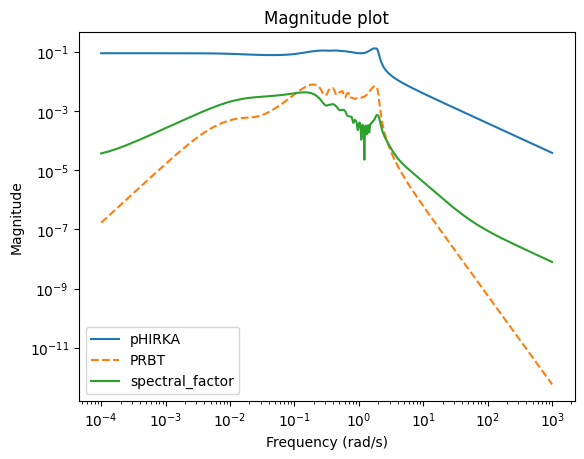

In [7]:
import matplotlib.pyplot as plt
w = (1e-4, 1e3)
fig, ax = plt.subplots()
err1.transfer_function.mag_plot(w, ax=ax, label='pHIRKA')
err2.transfer_function.mag_plot(w, ax=ax, linestyle='--', label='PRBT')
err3.transfer_function.mag_plot(w, ax=ax, label='spectral_factor')
_ = ax.legend()

Download the code:
{download}`tutorial_ph.md`,
{nb-download}`tutorial_ph.ipynb`.